## LSTM 사용 Text 분류 모델 구현 - 스팸메일 분류
: Keras의 Embedding,LSTM,Dropout 계층 사용

### 1. 라이브러리 가져오기

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

### 2. Spam and Ham 분류 테스트 데이터 셋 읽어오기

In [9]:
# 'spam.csv' 파일을  ',' 구분자로 읽어 df 에 저장하세요 (encoding='latin-1' 적용 )
# ... your code
# 'spam.csv' 파일을 ',' 구분자로 읽어 df에 저장
df = pd.read_csv('spam.csv', delimiter = ',',encoding='latin-1')
print(df.shape)
print(df['v2'][0], df['v1'][0])
df.head(20)

(5572, 5)
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ham


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### 3. 데이터 전처리 및 학습용/테스트용 준비하기
#### 3.1 불필요한 컬럼 삭제

In [10]:
# 'Unnamed: 2','Unnamed: 3','Unnamed: 4' 세개의 컬럼을 삭제하세요.
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
# drop 한 후에 저장 할 시, inplace = True를 쓸 것
df.head(20)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [11]:
# 'v1' 컬럼의 각 항목과 갯수를 파악하세요 
class_name = df['v1'].value_counts()
class_name

ham     4825
spam     747
Name: v1, dtype: int64

#### 3.2 클래스 분포 시각화

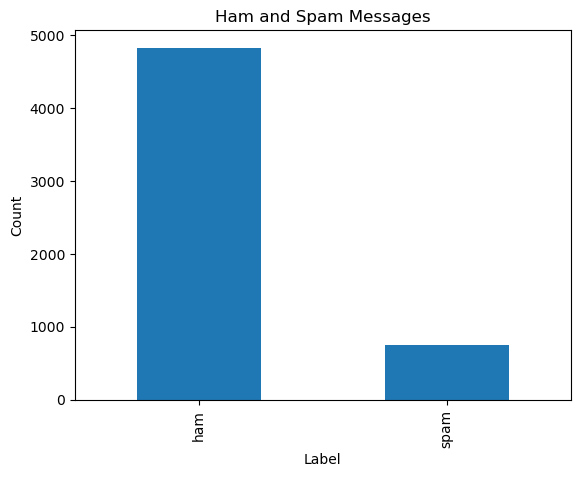

In [13]:
# class_name 을 막대 그래프로 시각화하세요 .
class_name = df['v1'].value_counts()

# 막대 그래프로 시각화
class_name.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Ham and Spam Messages')
plt.show()

#### 3.3 입력 및 레이블 데이터 정의하고 레이블 인코딩 
- Y 값을 0, 1로 변환 : LabelEncoder()

In [14]:
#1. X 에는 v2 컬럼, Y 에는 v1 컬럼을 지정하고 Y 컬럼은 LabelEncoder() 를 적용하세요.
X = df['v2'] # = df.v2 도 같은 값을 불러옴
Y = df['v1'] # = df.v1 도 같은 값을 불러옴 

print("before", Y.shape)

#2. LabelEncoder()의 인스턴스 le를 생성
le = LabelEncoder()

#3. Y에 fit_transform()를 실행하여 Y 값이 0(ham), 1(spam)로 변환
Y = le.fit_transform(Y)
#4. le = lableEncoder, 객체의 인스턴스 

#5. Y의 shape을 2차원으로 변경
Y = Y.reshape(-1, 1)

print("after", Y.shape)

before (5572,)
after (5572, 1)


레이블 인코딩의 주요 목적은 다음과 같습니다:

1. 알고리즘 입력용 데이터 준비: 
- 많은 머신 러닝 및 딥 러닝 알고리즘은 입력 데이터가 수치 데이터여야 합니다. 
- 범주형 데이터(예: 텍스트 레이블 또는 범주)를 수치 데이터로 변환하여 모델에 입력할 수 있도록 준비합니다.

2. 범주형 변수의 순서 정보 제공: 
- 레이블 인코딩은 범주의 순서를 나타내는 데 유용합니다. 
- 예를 들어, 'low', 'medium', 'high'와 같은 범주를 0, 1, 2와 같은 수치로 매핑하여 
- 알고리즘에 범주의 상대적인 순서를 전달할 수 있습니다.

3. 범주형 변수의 차원 축소: 
- 범주형 변수를 원-핫 인코딩과 같은 방식으로 처리하면 변수의 차원이 증가하므로, 
- 레이블 인코딩은 차원을 줄이고 메모리 사용량을 감소시킬 수 있습니다.

4. 텍스트 분류와 같은 작업에 유용: 
- 텍스트 데이터에서 클래스 레이블을 숫자로 인코딩하여 텍스트 분류 모델을 학습하는 데 사용됩니다.

5. 카테고리 분석: 
- 레이블 인코딩은 범주형 데이터의 통계 분석 및 시각화에 유용할 수 있으며, 
- 머신 러닝 모델에 데이터를 제공하기 전에 전처리 단계로 활용될 수 있습니다.

# 이 예제에서 레이블 인코딩을 쓰는 이유는?

- 주어진 코드에서 레이블 인코딩은 'ham'과 'spam'이라는 클래스 레이블을 
- 0과 1로 변환하여 스팸 필터링 모델을 학습하기 위한 데이터 준비를 수행합니다. 
- 이렇게 변환된 레이블을 사용하여 모델이 스팸 메시지와 일반 메시지를 구분하는 데 활용합니다.

#### 3.4 학슴용/테스트용 데이터셋 분리하기

In [15]:
# X, Y를 train과 test 데이터셋으로 분리 (test_size: 0.3)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(3900,) (1672,) (3900, 1) (1672, 1)


### 문장을 토큰화 처리, 패딩, 데이터셋의 길이를 설정

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, #**kwargs
# )

In [16]:
# 토큰나이저를 시행하여 단어를 숫자값, 인덱스로 변환하여 저장
max_words = 1000  # V, vocab_size
max_len = 150     # T, sequence_length, 한 문장의 길이, 데이터 셋의 길이

tok = Tokenizer(num_words=max_words) # 가장 빈도가 높은 1000개의 단어들만 사용하여 토큰화
# 단어 인덱스를 구축
tok.fit_on_texts(X_train)  # 인덱스 범위 : 0 ~ 999

In [17]:
# tok 에 처리된 내용 : 내부적으로만 가지고 있음
print(tok.word_index, "\n")  # 각 단어에 할당된 고유한 정수 인덱스를 나타내는 딕셔너리

# 예: {'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5,....,  'acl03530150pm': 7337} 

print(tok.word_counts , "\n") # 단어의 빈도를 나타내는 딕셔너리

# 예: OrderedDict([('haha', 70), ('hope', 152), ('ì', 182),... , ('09061701444', 2), ('acl03530150pm', 2)])

print(tok.word_docs, "\n" ) # 각 단어가 몇 개의 텍스트에서 등장했는지 나타내는 딕셔너리

# 예: defaultdict(<class 'int'>, {'can': 526, 'sound': 18, 'haha': 70, .. , 'acl03530150pm': 2, '09061701444': 2})

print(tok.document_count , "\n") # 피팅된 텍스트 문서의 총 개수

# 결과 : 7800 

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'of': 14, 'it': 15, 'call': 16, 'have': 17, 'on': 18, '2': 19, 'now': 20, 'are': 21, 'that': 22, 'so': 23, 'but': 24, 'not': 25, 'at': 26, 'or': 27, 'ur': 28, 'get': 29, "i'm": 30, 'will': 31, 'do': 32, 'just': 33, 'can': 34, 'be': 35, 'if': 36, 'we': 37, 'with': 38, 'no': 39, 'this': 40, 'lt': 41, 'gt': 42, '4': 43, 'free': 44, 'up': 45, 'when': 46, 'ok': 47, 'go': 48, 'from': 49, 'what': 50, 'how': 51, 'all': 52, 'know': 53, 'out': 54, 'then': 55, 'like': 56, 'am': 57, 'got': 58, 'come': 59, 'its': 60, 'good': 61, 'only': 62, 'was': 63, 'time': 64, 'love': 65, 'send': 66, 'day': 67, 'text': 68, 'there': 69, 'want': 70, 'txt': 71, 'going': 72, 'home': 73, 'he': 74, 'by': 75, 'still': 76, 'lor': 77, 'one': 78, 'as': 79, 'da': 80, 'sorry': 81, 'need': 82, 'stop': 83, 'r': 84, "i'll": 85, 'see': 86, 'about': 87, 'reply': 88, 'today': 89, 'hi': 90, 'mobile': 91, 'ba

`tok.fit_on_texts(X_train)` :  `Tokenizer` 클래스의 한 메소드로, 주어진 텍스트 데이터에 대한 토큰화를 수행하기 위한 준비 작업 진행함
1. 텍스트 정규화와 토큰화
- 모든 텍스트를 소문자로 변환합니다.
- 구두점(punctuation)을 제거하고, 단어를 토큰으로 분리합니다.

2. 단어 빈도수 계산
- 각 단어가 몇 번 나타나는지 세어서 빈도수를 계산합니다.

3. 단어 인덱스 생성
- 가장 자주 나타나는 단어부터 시작하여, 각 단어에 고유한 정수 인덱스 할당
- 예:가장 빈도수가 높은 단어에 1을 할당, 두 번째로 높은 단어에 2를 할당하는 식으로
- 이 때 `num_words` 파라미터를 사용해서, 빈도수가 가장 높은 상위 N개의 단어만을 선택할 수 있음

4. 결과 저장
- 이 모든 정보를 내부적으로 저장하여, 후에 `texts_to_sequences` 또는 `texts_to_matrix` 메소드를 통해 텍스트를 숫자 시퀀스나 바이너리 행렬로 변환할 수 있게 함

### 텍스트를 정수 시퀀스로 변환

In [18]:
# 문자열을 정수 인덱스의 리스트로 변환
sequences = tok.texts_to_sequences(X_train) # type은 list
print(X_train[:2])
print(sequences[:2])      # 길이가 서로 다름

708     To review and KEEP the fantastic Nokia N-Gage ...
4338                   Just got outta class gonna go gym.
Name: v2, dtype: object
[[2, 7, 203, 5, 921, 188, 93, 599, 38, 730, 188, 48, 19, 131, 182, 679, 49, 88, 38, 5, 329, 54], [33, 58, 256, 209, 48, 785]]


`tok.texts_to_sequences(X_train)` 메서드 : 텍스트 데이터를 정수의 시퀀스로 변환함. 
이 작업은 `Tokenizer` 객체가 `fit_on_texts` 메서드를 통해 학습된 단어 인덱스를 기반으로 이루어집니다. 여기서 진행하는 구체적인 작업은 다음과 같습니다:

1. 텍스트 정규화와 토큰화
- 입력된 텍스트 데이터를 소문자로 변환하고, 구두점을 제거한 후 단어 단위로 분리함

2. 단어를 정수로 변환
- 각 단어를 `fit_on_texts` 메서드에서 생성된 단어 인덱스를 사용하여 해당하는 정수로 변환함
- 예: "I love natural language processing"라는 문장이 있고, 단어 인덱스가 {"i": 1, "love": 2, "natural": 3, "language": 4, "processing": 5}라면, 이 문장은 [1, 2, 3, 4, 5]로 변환됨.

3. `num_words` 파라미터 고려
- `Tokenizer` 객체를 생성할 때 `num_words` 파라미터를 설정했다면, 이 파라미터를 고려하여 상위 `num_words - 1` 개의 단어만을 사용하여 시퀀스를 생성함. 0번 인덱스는 패딩을 위해 예약되어 있기 때문에 `-1`을 합니다.
    - 패딩: 데이터 포인트의 길이를 동일하게 만들기 위해 특정 값을 추가하는 것으로 텍스트 데이터에서는 주로 문장의 끝에 0 또는 다른 특정 값을 추가하여 모든 문장을 동일한 길이로 만듬.
    - 0이 패딩을 위해 사용
    - 패딩은 주로 순환 신경망(RNN)과 같이 시퀀스 데이터를 처리하는 모델에서 중요한 역할을 하며 패딩 사용하면 모든 시퀀스가 동일한 길이를 갖게되어 학습에 용이함
- 예: `num_words`가 1000이라면, 빈도수 기준 상위 999개의 단어만을 사용하여 시퀀스를 생성하고, 나머지 단어들은 무시함

4. 결과 반환
- 변환된 정수 시퀀스를 리스트의 형태로 반환함

### 시퀀스 패딩
 시퀀스 패딩:
```python
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
```
`pad_s : uences` 함수는 시퀀스(정수의 리스트)의 리스트를 입력으로 받아, 모든 시퀀스가 같함
- 를 갖도록 패딩합니다. ` : xlen` 파라미터는 시퀀함최
    -   길이를 지정합니다. 만약 시퀀스의 길이가 `maxlen`보다 짧다면, 시퀀스의 시작 부분에 0춤가
    -  여 길이를 맞춥니다. 만약 시퀀스의 길이가 `maxlen`보다 길다면, 시퀀스의 시작 부분춤 모델에 입력으로 사용될 준비가 되었습니다.


In [ ]:
# 벡터 표현을 얻음 - 신경망 모델에 입력으로 사용
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len) # 신경망에 입력할 X값이다
print(sequences_matrix.shape)  # (3900, 150), 2차원 행렬

### 단어 인덱스 및 어휘 크기 확인

```python
word_to_index = tok.word_index
vocab_size = len(word_to_index)
```
- `word_index` 속성 : 텍스트 데이터에 있는 각 단어와 해당 단어에 할당된 정수 인덱스를 나타내는 딕셔너리
- `vocab_size` : 어휘의 크기, 즉 고유한 단어의 개수를 나타냄

In [ ]:
word_to_index = tok.word_index
# print(word_to_index)
vocab_size = len(word_to_index)
print(vocab_size)

`sequence.pad_sequences(sequences, maxlen=max_len)` 함수 :시퀀스(여기서는 단어의 정수 인덱스 리스트)의 길이를 일정하게 맞추기 위해 패딩(padding)을 추가하는 작업을 수행함. 이 함수는 Keras 라이브러리의 일부로, 신경망에 입력할 데이터의 형태를 통일시키기 위해 사용됩니다. 

1. 시퀀스 길이 조정
- 모든 시퀀스의 길이를 `maxlen` 파라미터로 지정된 값으로 맞춥니다.
- 시퀀스의 길이가 `maxlen`보다 짧다면, 지정된 위치(기본값은 앞쪽)에 0을 추가하여 길이를 맞춥니다.
- 시퀀스의 길이가 `maxlen`보다 길다면, 지정된 위치에서 일부 데이터를 잘라내어 길이를 맞춥니다.

2. 패딩 추가
- `padding` 파라미터를 사용하여 패딩을 어디에 추가할지 결정할 수 있습니다. `padding='pre'`이면 시퀀스 앞에 패딩을 추가하고, `padding='post'`이면 시퀀스 뒤에 패딩을 추가합니다.

3. 잘라내기 위치 설정
- `truncating` 파라미터를 사용하여 시퀀스를 잘라낼 위치를 결정할 수 있습니다. `truncating='pre'`이면 시퀀스 앞부분을, `truncating='post'`이면 시퀀스 뒷부분을 잘라냅니다.

4. 결과 반환
- 길이가 조정된 시퀀스들을 NumPy 배열의 형태로 반환함

예를 들어, 다음과 같은 시퀀스들이 있다고 가정해 봅시다:
```python
sequences = [[1, 2, 3], [4, 5, 6, 7], [8, 9]]
max_len = 3
```
`sequence.pad_sequences(sequences, maxlen=max_len)`을 실행하면 다음과 같은 결과를 얻을 수 있습니다:
```python
[[1, 2, 3],
 [5, 6, 7],
 [0, 8, 9]]
```
두 번째 시퀀스는 길이가 `max_len`보다 길어서 앞부분이 잘려나갔고, 세 번째 시퀀스는 길이가 짧아서 앞부분에 0이 추가되었습니다.

## RNN 신경망 모델 구현

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
tf.keras.layers.Embedding(
    input_dim, output_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=False, input_length=None, # **kwargs
)

input_dim : input_dim,V,max_words : 1000
output_dim : hidden_size , D , 50
input_length : sequence_length ,T : max_len:150

In [ ]:
from tensorflow.keras.layers import Embedding

# Embedding 레이어 설정
embedding_layer = Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len)

# 예시로 Embedding 레이어를 모델에 추가하는 방법
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(embedding_layer)

In [ ]:
# LSTM 1층을 사용하여 신경망을 구현 : Accuracy: 0.983
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words,50,input_length=max_len), # X:(?,150) W:(1000,50)=(?,150,50)
    tf.keras.layers.LSTM(32,return_sequences=True),  # (?,150,50) , W:(50,32) --> (?,150,32)
    tf.keras.layers.Dense(32,activation='relu'),     # (?,150,32) , W: (32,32)  --> (?,150,32)
    tf.keras.layers.Dropout(rate=0.5),                       # (?,150,32)
    tf.keras.layers.Flatten(),                       # (?,150*32) --> (?,4800)
    tf.keras.layers.Dense(1,activation='sigmoid')    # (?,4800), W:(4800,1) -->(?,1)
])

model.summary()

In [ ]:
print(max_words)
print(max_len)


In [ ]:
# LSTM 2층을 사용하여 신경망을 구현 :    Accuracy: 0.984,  2층의 정확도가 약간 높다
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, 50,input_length=max_len), # X:(?,150) W:(1000,50)=(?,150,50)
    tf.keras.layers.LSTM(32, return_sequences=True),  # (?,150,50) , W:(50,32) --> (?,150,32)
    tf.keras.layers.LSTM(32),                        # (?,150,50) , W:(50,32) --> (?,32)
    tf.keras.layers.Dense(32,activation='relu'),     # (?,32) , W: (32,32)  --> (?,32)
    tf.keras.layers.Dropout(rate=0.5),               # (?,32)
    tf.keras.layers.Flatten(),                       # (?,32) 
    tf.keras.layers.Dense(1,activation='sigmoid')    # (?,32), W:(32,1) -->(?,1)
])

1. Embedding 층
```python
tf.keras.layers.Embedding(max_words, 50, input_length=max_len)
```
- 이 층은 정수 인코딩된 단어들을 실수 벡터로 매핑하는 역할을 함
- `max_words`: 어휘 사전의 크기, 즉 모델이 처리할 수 있는 최대 단어 수
- `50`: 임베딩된 단어 벡터의 차원
- `input_length=max_len`: 입력 시퀀스의 길이, 여기서는 150으로 설정되어 있음
- 입력 데이터의 크기 : `(batch_size, 150)`
- 출력 데이터의 크기 : `(batch_size, 150, 50)`

2. LSTM 층
```python
tf.keras.layers.LSTM(32, return_sequences=True)
```
- 이 층은 Long Short-Term Memory (LSTM) 셀을 사용함( LSTM은 순차 데이터를 처리하기 위해 설계된 RNN(Recurrent Neural Network)의 한 종류임)
- `32`: LSTM 셀의 유닛 수
- `return_sequences=True`: 각 시퀀스에서 출력 시퀀스를 반환함
- 입력 데이터의 크기 : `(batch_size, 150, 50)`이
- 출력 데이터의 크기 : `(batch_size, 150, 32)`

3. LSTM 층:
```python
tf.keras.layers.LSTM(32)
```
- 이 층은 `return_sequences`가 기본값인 `False`로 설정되어 있어, 마지막 타임스텝의 출력만 반환
- 입력 데이터의 크기: `(batch_size, 150, 32)`
- 출력 데이터의 크기: `(batch_size, 32)`

In [ ]:
model.summary()

LSTM 층의 파라미터 수는 입력 차원, 출력 차원 (LSTM 셀의 수), 그리고 LSTM의 내부 구조에 따라 결정됩니다.

LSTM 셀은 다음과 같은 세 가지 게이트를 가지고 있습니다:

1. **Forget Gate**: 이전 상태를 얼마나 잊어버릴지 결정합니다.
2. **Input Gate**: 새로운 정보를 상태에 얼마나 추가할지 결정합니다.
3. **Output Gate**: 다음 상태로 출력할 정보의 양을 결정합니다.

각 게이트에는 입력, 이전 상태, 그리고 바이어스에 대한 가중치가 있습니다. 따라서 총 가중치 수는 \(3 \times (n_{\text{input}} + n_{\text{output}} + 1) \times n_{\text{output}}\)입니다. 여기서 \( n_{\text{input}} \)은 입력 차원, \( n_{\text{output}} \)은 출력 차원 (LSTM 셀의 수)입니다. LSTM에는 또한 셀 상태를 업데이트하는 데 사용되는 가중치가 있는데, 이것도 고려해야 합니다.

\( lstm_4 \) 층의 경우:

- 입력 차원: \( n_{\text{input}} = 50 \) (임베딩 차원)
- 출력 차원: \( n_{\text{output}} = 32 \) (LSTM 셀의 수)

파라미터 수는 다음과 같이 계산됩니다:

\[
4 \times (n_{\text{input}} + n_{\text{output}} + 1) \times n_{\text{output}} = 4 \times (50 + 32 + 1) \times 32 = 4 \times 83 \times 32 = 10,624
\]

여기서 4는 LSTM이 가지는 게이트 수 (3개)와 셀 상태를 업데이트하는 연산 (1개)을 합한 것입니다.

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
# RMSProp : https://forensics.tistory.com/28
# RMSprop 알고리즘은 Adadelta와 마찬가지로 Adagrad에서 학습률이 급격하게 감소하는 문제를 해결 

In [ ]:
# 학습
model.fit(sequences_matrix,Y_train,batch_size=128, epochs=10, validation_split=0.2)

### 정확도 측정

In [ ]:
#  Test 데이터셋의 벡터를 구함

# 문자열을 정수 인덱스의 리스트로 변환
test_sequences = tok.texts_to_sequences(X_test) 

# 벡터 표현을 얻음
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)  # 신경망에 입력할 X값이다
print(test_sequences_matrix.shape,Y_test.shape)  # (1672, 150), 2차원 행렬

In [ ]:
# 정확도
accr = model.evaluate(test_sequences_matrix,Y_test,  verbose=0)

In [ ]:
print('Test set\nLoss: {:0.3f}\nAccuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
# 예측
pred = model.predict(test_sequences_matrix[1].reshape(1,-1)) # test_sequences_matrix[1]은 1차원이므로
pred,Y_test[1]

In [ ]:
test_sequences_matrix[1]

In [ ]:
preds = model.predict(test_sequences_matrix[17].reshape(1,-1)) 
preds,Y_test[17]

In [ ]:
ones = np.where(Y_test==1)  # 답이 1인 인덱스
ones[0]

In [ ]:
for one in ones[0]:
    preds = model.predict(test_sequences_matrix[one].reshape(1,-1))
    print(preds,Y_test[one])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# 모든 테스트 데이터에 대해 예측 수행
predictions = model.predict(test_sequences_matrix)

# 예측 결과를 이진 클래스로 변환
binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

# 실제 레이블을 1차원 배열로 변환
y_true = np.array(Y_test).reshape(-1)

# 예측 결과와 실제 레이블을 데이터프레임으로 변환
#comparison_df = pd.DataFrame({'Actual': y_true, 'Predicted': binary_predictions})
results_df = pd.DataFrame({'Text': X_test, 'Actual': Y_test.reshape(-1), 'Predicted': binary_predictions})

# 분류 리포트 생성
report = classification_report(y_true, binary_predictions)

print(results_df.head())
print(report)
